In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện dùng để ẩn các warnings
import warnings
warnings.filterwarnings('ignore')

# Thư viện để xử lý các text entry
import fuzzywuzzy
from fuzzywuzzy import process

from pandas.api.types import CategoricalDtype

In [2]:
# Load dữ liệu và xem vài dòng đầu tiên của data.

df = pd.read_csv('D:\Pandora Box\datasets\VN_housing_dataset.csv')
df.head()

,Unnamed: 0,Ngày,Địa chỉ,Quận,Huyện,Loại hình nhà ở,Giấy tờ pháp lý,Số tầng,Số phòng ngủ,Diện tích,Dài,Rộng,Giá/m2
0,0.0,2020-08-05,"Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...",Quận Cầu Giấy,Phường Nghĩa Đô,"Nhà ngõ, hẻm",Đã có sổ,4,5 phòng,46 m²,NaN,NaN,"86,96 triệu/m²"
1,1.0,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà mặt phố, mặt tiền",NaN,NaN,3 phòng,37 m²,NaN,NaN,"116,22 triệu/m²"
2,2.0,2020-08-05,"phố minh khai, Phường Minh Khai, Quận Hai Bà T...",Quận Hai Bà Trưng,Phường Minh Khai,"Nhà ngõ, hẻm",Đã có sổ,4,4 phòng,40 m²,10 m,4 m,65 triệu/m²
3,3.0,2020-08-05,"Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...",Quận Tây Hồ,Phường Thụy Khuê,"Nhà ngõ, hẻm",Đã có sổ,NaN,6 phòng,51 m²,12.75 m,4 m,100 triệu/m²
4,4.0,2020-08-05,"Đường Kim Giang, Phường Kim Giang, Quận Thanh ...",Quận Thanh Xuân,Phường Kim Giang,"Nhà ngõ, hẻm",NaN,NaN,4 phòng,36 m²,9 m,4 m,"86,11 triệu/m²"


In [3]:
# Xem thông tin của data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82497 entries, 0 to 82496
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       82496 non-null  float64
 1   Ngày             82496 non-null  object 
 2   Địa chỉ          82449 non-null  object 
 3   Quận             82495 non-null  object 
 4   Huyện            82449 non-null  object 
 5   Loại hình nhà ở  82465 non-null  object 
 6   Giấy tờ pháp lý  53610 non-null  object 
 7   Số tầng          36399 non-null  object 
 8   Số phòng ngủ     82458 non-null  object 
 9   Diện tích        82495 non-null  object 
 10  Dài              19827 non-null  object 
 11  Rộng             35445 non-null  object 
 12  Giá/m2           82484 non-null  object 
dtypes: float64(1), object(12)
memory usage: 8.2+ MB


Đầu tiên chúng ta cần phải drop hoặc lấy Unnamed: 0 làm index, nó chỉ là id của các quan sát.

Thứ hai, ở đây có cột Huyện nhưng lại chứa dữ liệu Phường chắc chắn là người làm bộ data này nhầm lẫn, chúng ta sẽ sửa nó thành Phường.

In [4]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.rename({'Huyện': 'Phường'}, axis=1, inplace=True)

Chúng ta hạn chế để data ở kiểu object. Kiểu object không chỉ là string, mà list, set, dict cũng đều được coi là object

"Địa chỉ", mình sẽ để nguyên là object. Vì clean nó thực sự mất rất nhiều thời gian, nó là nồi thập cẩm với đủ loại định dạng và typos.<br>
"Quận", "Số phòng ngủ", mình sẽ đưa về category, nhưng ở đây sẽ có 2 kiểu category.<br>

# 1. Norminal Category

In [6]:
df['Quận'].unique()

array(['Quận Cầu Giấy', 'Quận Thanh Xuân', 'Quận Hai Bà Trưng',
       'Quận Tây Hồ', 'Quận Đống Đa', 'Quận Hà Đông', 'Huyện Thanh Trì',
       'Quận Hoàng Mai', 'Quận Long Biên', 'Quận Hoàn Kiếm',
       'Quận Nam Từ Liêm', 'Quận Ba Đình', 'Huyện Hoài Đức',
       'Quận Bắc Từ Liêm', 'Huyện Đan Phượng', 'Huyện Thanh Oai',
       'Huyện Sóc Sơn', 'Huyện Gia Lâm', 'Huyện Chương Mỹ',
       'Huyện Đông Anh', 'Huyện Thường Tín', 'Thị xã Sơn Tây',
       'Huyện Mê Linh', 'Huyện Thạch Thất', 'Huyện Quốc Oai',
       'Huyện Phúc Thọ', 'Huyện Phú Xuyên', 'Huyện Ba Vì', nan,
       'Huyện Mỹ Đức'], dtype=object)

Mình sẽ fillna với 'missing', còn các giá trị còn lại sẽ split rồi lấy join [1:]


In [7]:
df['Quận'].fillna('missing', inplace=True)

df['Quận'] = df['Quận'].str.split()
df['Quận'] = df['Quận'].apply(lambda x: ' '.join(x[1:]) if len(x) > 1 else x[0])

df['Quận'].replace('xã Sơn Tây', 'Sơn Tây', inplace=True)

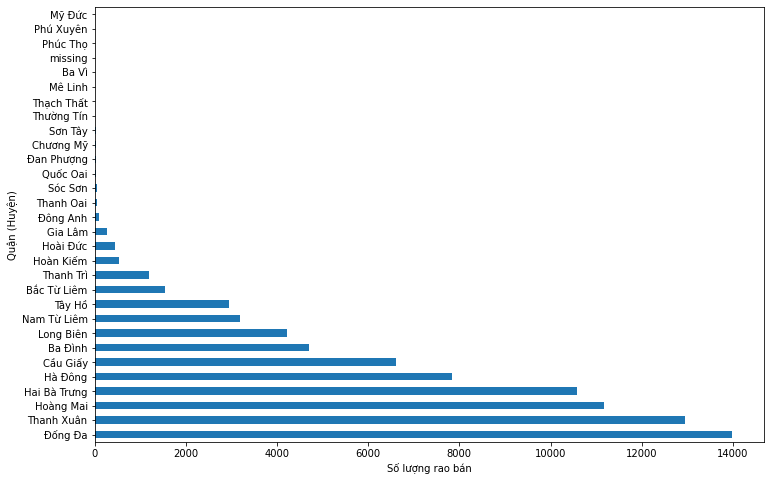

In [8]:
plt.figure(figsize=(12, 8))
df['Quận'].value_counts().plot(kind='barh')
plt.xlabel('Số lượng rao bán')
plt.ylabel('Quận (Huyện)')
plt.show()

Sau đó mình sẽ chuyển data-type của 'Quận' sang 'category'.

Nếu các giá trị của 1 cột là hữu hạn, ta nên đưa nó về category, nó sẽ giúp tiết kiệm khá nhều bộ nhớ, cũng như có thể sử dụng các thao tác khác, mà kiểu object không thể, mặc dù cả hai đều chứa string.<br>
Trong trường hợp, côt đó chứa feedback, hoặc description của sản phẩm, thì ta sẽ để nó ở kiểu object.

In [9]:
before = df['Quận'].memory_usage()
print(f'Trước khi chuyển sang categoy: {before}')

Trước khi chuyển sang categoy: 660104


In [10]:
df['Quận'] = df['Quận'].astype('category')

after = df['Quận'].memory_usage()
print(f'Sau khi chuyển sang category: {after}')
print(f'Giảm tới: {(before - after) / before * 100}%')

Sau khi chuyển sang category: 83937
Giảm tới: 87.28427641704943%


# Giảm tới: 87.28427641704943% đó quý zị ạ

Hoặc ta có thể Encode, sắp xếp, so sánh (nếu như đó là ordinal category).

In [11]:
df['Quận'].cat.categories

Index(['Ba Vì', 'Ba Đình', 'Bắc Từ Liêm', 'Chương Mỹ', 'Cầu Giấy', 'Gia Lâm',
       'Hai Bà Trưng', 'Hoài Đức', 'Hoàn Kiếm', 'Hoàng Mai', 'Hà Đông',
       'Long Biên', 'Mê Linh', 'Mỹ Đức', 'Nam Từ Liêm', 'Phú Xuyên',
       'Phúc Thọ', 'Quốc Oai', 'Sóc Sơn', 'Sơn Tây', 'Thanh Oai', 'Thanh Trì',
       'Thanh Xuân', 'Thường Tín', 'Thạch Thất', 'Tây Hồ', 'missing',
       'Đan Phượng', 'Đông Anh', 'Đống Đa'],
      dtype='object')

In [12]:
df['Quận'].cat.codes[:5]

0     4
1    22
2     6
3    25
4    22
dtype: int8

In [13]:
df['Quận'].head()

0        Cầu Giấy
1      Thanh Xuân
2    Hai Bà Trưng
3          Tây Hồ
4      Thanh Xuân
Name: Quận, dtype: category
Categories (30, object): ['Ba Vì', 'Ba Đình', 'Bắc Từ Liêm', 'Chương Mỹ', ..., 'missing', 'Đan Phượng', 'Đông Anh', 'Đống Đa']

# 2. Ordinal Category

Việc chuyển sang Ordinal Category cũng giống như Norminal Category vậy. Nhưng ta sẽ thêm vào đó order của các giá trị.<br>
Ví dụ, 'thấp' < 'trung bình' < 'cao' - chính là 1 ordinal category.

In [14]:
df['Giấy tờ pháp lý'].fillna('missing', inplace=True)

In [15]:
df['Giấy tờ pháp lý'].unique()

array(['Đã có sổ', 'missing', 'Đang chờ sổ', 'Giấy tờ khác'], dtype=object)

Ở đây ta có 'Đã có sổ', nan, 'Đang chờ sổ', 'Giấy tờ khác', vậy ta có thể tưởng tượng trong đầu ra thứ tự của nó.<br>

'missing < 'Giấy tờ khác' < 'Đang chờ sổ' < 'Đã có sổ'

### Trước khi chuyển sang ordinal category

In [16]:
df[df['Giấy tờ pháp lý'] > 'Giấy tờ khác']['Giấy tờ pháp lý'].unique()

Trước khi chuyển sang ordinal category


array(['Đã có sổ', 'missing', 'Đang chờ sổ'], dtype=object)

In [17]:
df['Giấy tờ pháp lý'] = df['Giấy tờ pháp lý'].astype(CategoricalDtype(categories=['missing', 'Giấy tờ khác', 'Đang chờ sổ', 'Đã có sổ'],
                                                                      ordered=True))

### Sau khi chuyển sang ordinal category

In [18]:
df[df['Giấy tờ pháp lý'] > 'Giấy tờ khác']['Giấy tờ pháp lý'].unique()

Sau khi chuyển sang ordinal category


['Đã có sổ', 'Đang chờ sổ']
Categories (2, object): ['Đang chờ sổ' < 'Đã có sổ']

In [19]:
df['Giấy tờ pháp lý']

0        Đã có sổ
1         missing
2        Đã có sổ
3        Đã có sổ
4         missing
           ...   
82492     missing
82493    Đã có sổ
82494    Đã có sổ
82495     missing
82496     missing
Name: Giấy tờ pháp lý, Length: 82497, dtype: category
Categories (4, object): ['missing' < 'Giấy tờ khác' < 'Đang chờ sổ' < 'Đã có sổ']

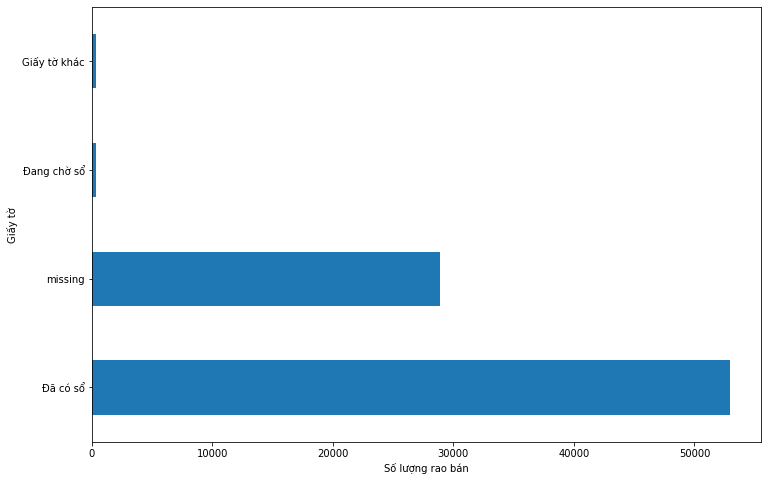

In [20]:
plt.figure(figsize=(12, 8))
df['Giấy tờ pháp lý'].value_counts().plot(kind='barh')
plt.xlabel('Số lượng rao bán')
plt.ylabel('Giấy tờ')
plt.show()